# OHBM 2020 - Open Science Room - Neurolang

## Priors and  increased specificity

### Background
The increasing availability of information describing cognitive structures and processes is a powerful driver for the adoption of meta-analysis techniques that help to synthesize large bodies of data from different studies[3-5]. This situation has also given rise to the advent of automated meta-analysis techniques, such as Neurosynth[1], which try to alleviate the high burden that information processing requires, to obtain a better performance for the volume of data processed. 

Since NeuroSynth was designed to extract information automatically, solving the problem generated by the explosive growth of human brain imaging literature in recent years[6], the results do not always have the required accuracy and specificity[2].

### Our approach
In this work, We present a possible solution to some of these problems through the use of priors. We are going to show how we can add a prior to the results obtained through meta-analysis techniques, allowing us to specify the region in a precise manner, reducing the area covered by the responses obtained, thus decreasing the variance and increasing the statistical power of the analysis.

#### Let's begin

In [3]:
%load_ext snakeviz

In [4]:
import warnings
warnings.filterwarnings('ignore')

import stats_helper, datasets_helper
from neurolang.frontend.probabilistic_frontend import ProbabilisticFrontend
from rdflib import RDFS
from nilearn import plotting
import numpy as np
from matplotlib import pyplot as plt
from typing import Iterable
from neurolang import frontend as fe

We will use the FMA ontology to obtain regions of the brain included within the `Temporal lobe`. We will obtain all the entities that make up the `Temporal Lobe` and then we will convert them into regions using the information provided by the Destrieux atlas. This will allow us to perform spatial operations on these regions, allowing us to obtain those NeuroSynth regions associated with the term `auditory` that overlap our results.



In [5]:
nl = ProbabilisticFrontend()
datasets_helper.load_auditory_datasets(nl, n=100)

In [6]:
paths = 'neurolang_data/ontologies/neurofma_fma3.0.owl'
nl.load_ontology(paths)

In [7]:
label = nl.new_symbol(name=str(RDFS.label))
subclass_of = nl.new_symbol(name=str(RDFS.subClassOf))
regional_part = nl.new_symbol(name='http://sig.biostr.washington.edu/fma3.0#regional_part_of')

@nl.add_symbol
def agg_create_region(x: Iterable, y: Iterable, z: Iterable) -> fe.ExplicitVBR:
    mni_t1 = it.masker.volume
    voxels = nib.affines.apply_affine(np.linalg.inv(mni_t1.affine), np.c_[x, y, z])
    return fe.ExplicitVBR(voxels, mni_t1.affine, image_dim=mni_t1.shape)

with nl.environment as e:    
    e.fma_related_region[e.subregion_name, e.fma_uri] = (
        label(e.xfma_entity_name, e.fma_uri) & 
        regional_part(e.fma_region, e.xfma_entity_name) & 
        subclass_of(e.fma_subregion, e.fma_region) &
        label(e.fma_subregion, e.subregion_name)
    )
    e.fma_related_region[e.recursive_region, e.fma_name] = (
        subclass_of(e.recursive_region, e.fma_subregion) & e.fma_related_region(e.fma_subregion, e.fma_name)
    )
    e.fma_to_destrieux[e.fma_name, e.destrieux_name] = (
        label(e.fma_uri, e.fma_name) & e.relation_destrieux_fma(e.destrieux_name, e.fma_name)
    )

In [9]:
%%snakeviz

with nl.environment as e:
    e.region_voxels[e.id_neurosynth, e.x, e.y, e.z] = (
        e.fma_related_region[e.fma_subregions, 'Temporal lobe'] & 
        e.fma_to_destrieux[e.fma_subregions, e.destrieux_name] & 
        e.destrieux_to_neurosynth[e.destrieux_name, e.id_neurosynth, e.x, e.y, e.z]
    )
    
    e.destrieux_to_neurosynth[e.destrieux_name, e.id_neurosynth, e.x, e.y, e.z] = (
        e.destrieux_labels[e.id_destrieux, e.destrieux_name] &
        e.xyz_destrieux[e.x, e.y, e.z, e.id_destrieux] &
        e.xyz_neurosynth[e.x, e.y, e.z, e.id_neurosynth]
    )
    
    e.p_act[e.id_voxel, e.term, e.id_study] = (
        e.p_voxel_study[e.id_voxel, e.id_study] & 
        e.p_term_study[e.term,  e.id_study] & 
        e.p_study[e.id_study]
    )
    
    e.probability_voxel[e.x, e.y, e.z] = (
        e.p_act[e.id_voxel, e.term, e.id_study] &
        e.region_voxels[e.id_voxel, e.x, e.y, e.z]
    )
    
    nl_results = nl.solve_query(e.probability_voxel[e.x, e.y, e.z])
    
    #e.probability_voxel[nl.symbols.agg_create_region(e.x, e.y, e.z)] = (
    #    e.p_act[e.id_voxel, e.term, e.id_study] &
    #    e.region_voxels[e.id_voxel, e.x, e.y, e.z]
    #)
    
    #e.final[e.region] = e.probability_voxel[e.region]
    
    #nl_results = nl.solve_query(e.final[e.region])

 
*** Profile stats marshalled to file '/var/folders/dp/jss5gg557c78z1jk8d9knnbc0000gn/T/tmp_kjpoxlz'. 
Embedding SnakeViz in this document...


/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:435: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/frontend/neurosynth_data/dataset.pkl'>
  dataset = pickle.load(open(filename, 'rb'))
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:771: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  columns=self.data['columns']).to_sparse()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/displays.py:1239: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if (not isinstance(cut_coords, collections.Sequence) and
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error fo

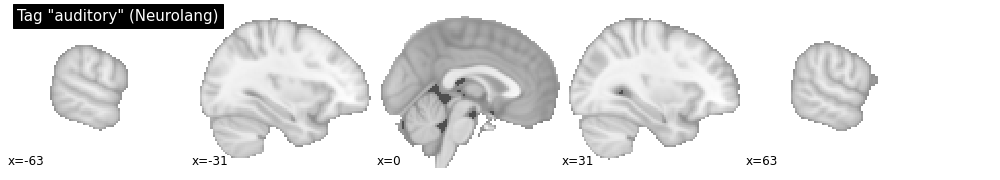

In [6]:
prob_img_nl = datasets_helper.parse_results(nl_results)
plotting.plot_stat_map(
    prob_img_nl, 
    title='Tag "auditory" (Neurolang)', 
    cmap='PuBuGn',
    display_mode='x',
    cut_coords=np.linspace(-63, 63, 5),
)

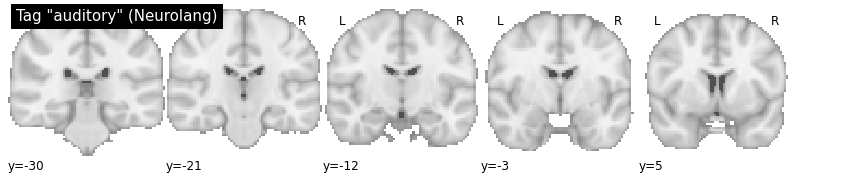

In [7]:
plotting.plot_stat_map(
    prob_img_nl, title='Tag "auditory" (Neurolang)', 
    cmap='PuBuGn',
    display_mode='y',
    cut_coords=np.linspace(-30, 5, 5),
)

In [8]:
with nl.environment as e:
    
    e.p_act[e.id_voxel, e.term, e.id_study] = (
        e.p_voxel_study[e.id_voxel, e.id_study] & 
        e.p_term_study[e.term,  e.id_study] & 
        e.p_study[e.id_study]
    )
    
    e.probability_voxel[e.x, e.y, e.z] = (
        e.p_act[e.id_voxel, e.term, e.id_study] &
        e.region_voxels[e.id_voxel, e.x, e.y, e.z]
    )
    
    ns_results = nl.solve_query(e.probability_voxel[e.x, e.y, e.z])

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:146: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/probabilistic/weighted_model_counting.py:521: RuntimeWarning: divide by zero encountered in log
  wmc.set_literal_weights_from_array(np.log(weights))


/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:435: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/frontend/neurosynth_data/dataset.pkl'>
  dataset = pickle.load(open(filename, 'rb'))
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:771: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  columns=self.data['columns']).to_sparse()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


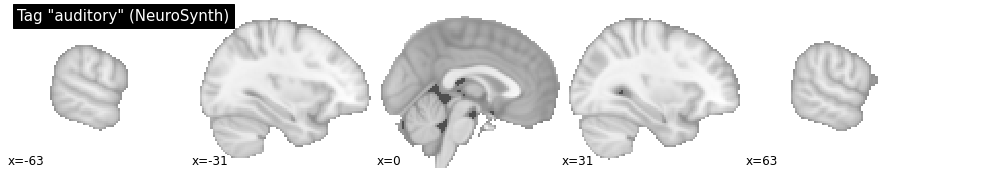

In [9]:
prob_img_ns = datasets_helper.parse_results(ns_results)
plotting.plot_stat_map(
    prob_img_ns, 
    title='Tag "auditory" (NeuroSynth)', 
    cmap='PuBu',
    display_mode='x',
    cut_coords=np.linspace(-63, 63, 5),
)

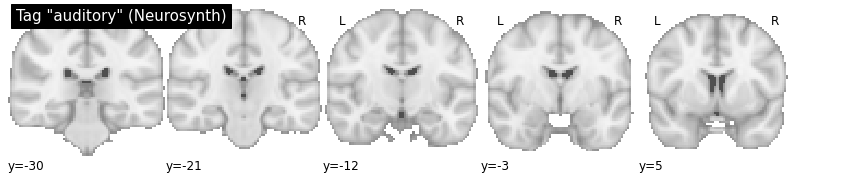

In [10]:
plotting.plot_stat_map(
    prob_img_ns, 
    title='Tag "auditory" (Neurosynth)', 
    cmap='PuBu',
    display_mode='y',
    cut_coords=np.linspace(-30, 5, 5),
)

Now we can analyze the results by plotting the p-values obtained. Let's start with the NeuroLang results.

In [23]:
res, p_values_corrected, p_value_image = stats_helper.compute_p_values(prob_img, q=1e-25)

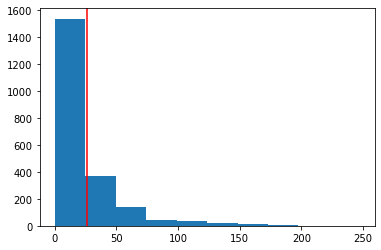

In [24]:
plt.hist(-np.log10(res))
plt.axvline(-np.log10(p_values_corrected), c='r')

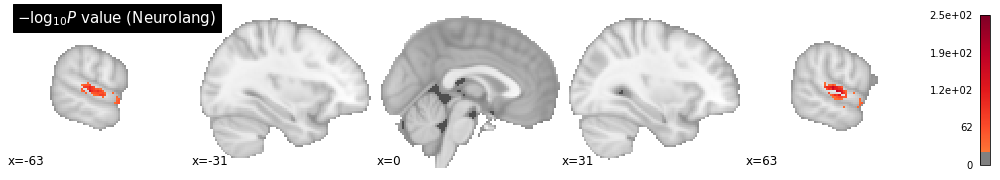

In [25]:
plotting.plot_stat_map(
    p_value_image, 
    title=r'$-\log_{10} P$ value (Neurolang)', 
    threshold=-np.log10(p_values_corrected), 
    cmap='YlOrRd',
    display_mode='x',
    cut_coords=np.linspace(-63, 63, 5),
)

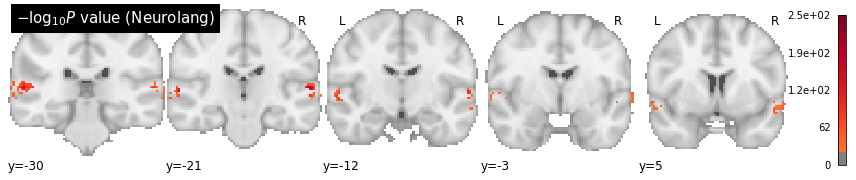

In [26]:
plotting.plot_stat_map(
    p_value_image, title=r'$-\log_{10} P$ value (Neurolang)', 
    threshold=-np.log10(p_values_corrected),
    cmap='YlOrRd',
    display_mode='y',
    cut_coords=np.linspace(-30, 5, 5),
)

In the above results, we can see that the regions have a high specificity and that they focus entirely on our area of interest. Reducing the area of work in this way allows us to minimize variance, enabling us to obtain results with greater statistical power.

And now let's do the same with the NeuroSynth results to compare. It is important to mention that the techniques used for the calculation of the p-values, make a comparison against the average of the activations. Bearing this in mind, by decreasing the region to be analyzed and focusing it on the activated region, the average of the activations increases.

In [27]:
res, p_values_corrected, p_value_image = stats_helper.compute_p_values(prob_img_ns, q=1e-25)

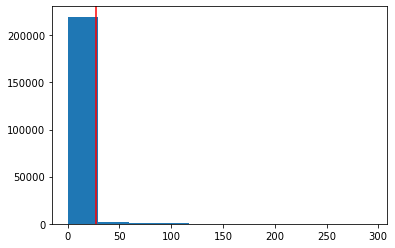

In [28]:
plt.hist(-np.log10(res))
plt.axvline(-np.log10(p_values_corrected), c='r')

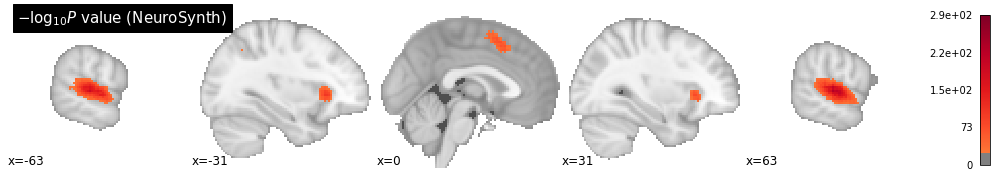

In [29]:
plotting.plot_stat_map(
    p_value_image, 
    title=r'$-\log_{10} P$ value (NeuroSynth)', 
    threshold=-np.log10(p_values_corrected), 
    cmap='YlOrRd',
    display_mode='x',
    cut_coords=np.linspace(-63, 63, 5),
)

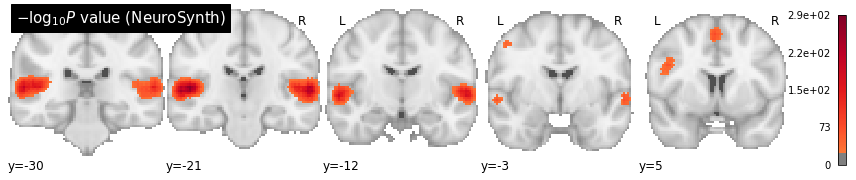

In [30]:
plotting.plot_stat_map(
    p_value_image, title=r'$-\log_{10} P$ value (NeuroSynth)', 
    threshold=-np.log10(p_values_corrected),
    cmap='YlOrRd',
    display_mode='y',
    cut_coords=np.linspace(-30, 5, 5),
)

It can be seen above how despite using a restrictive threshold for the p-value ($q<10^{25}$, FDR corrected), in the Neurosynth example there are activations considered statistically significant in the motor cortex that should not be present for the `auditory` tag. Using a prior information in NeuroLang, we are able to remove these false positives and obtain a cleaner result. 

#### References
[1] Yarkoni, T.: Neurosynth core tools v0.3.1, DOI: 10.5281/zenodo.9925 (2014). <br/>
[2] Yarkoni, T., Poldrack, R. A., Nichols, T. E., Van Essen, D. C. & Wager, T. D: Large-scale automated synthesis of human functional neuroimaging data. Nat. Methods 8, 665–670, DOI: 10.1038/nmeth.1635 (2011). <br/>
[3] News. Journal of Investigative Medicine 58 (8), 929 (Dec2010). https://doi.org/10.2310/JIM.0b013e3182025955, http://jim.bmj.com/content/58/8/929.abstract <br/>
[4] Insel, T. R., Landis, S.C., Collins, F.S.: Research priorities. The NIHBRAIN Initiative. Science (New York, N.Y.) 340 (6133), 687–688 (May  2013). https://doi.org/10.1126/science.1239276 <br/>
[5] Markram, H.: The human brain project. Scientific American306(6), 50–55 (Jun2012). https://doi.org/10.1038/scientificamerican0612-50
[6] Derrfuss, J. & Mar, R. A. Lost in localization: the need for a universal coordinate database. NeuroImage 48, 1–7, DOI:10.1016/j.neuroimage.2009.01.053 (2009).